In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import seaborn as sns
from wordcloud import wordcloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics

In [2]:
import tensorflow

print(tensorflow.__version__)

2.17.1


In [3]:
import keras
print(keras.__version__)

3.5.0


# Import data

In [9]:
twt_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sent Analysis/Tweets.csv')
twt_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
twt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [13]:
twt_df = twt_df.dropna()

In [14]:
# Check for null values in each column
twt_df.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [15]:
twt_df.duplicated().sum()

0

In [17]:

# Drop selected text and textid
twt_df = twt_df.drop(columns = ["selected_text", "textID"])

In [19]:
twt_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [20]:
twt_df["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [24]:
import plotly.express as px

# Calculate value counts and reset index for Plotly Express
sentiment_counts = twt_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']  # Rename columns

# Create the bar chart
fig = px.bar(
    sentiment_counts,
    x='sentiment',
    y='count',
    title='Distribution of Sentiments',
    labels={'sentiment': 'Sentiment', 'count': 'Number of Tweets'}
)
fig.show()

In [30]:
# obtain word count feature
twt_df["word_count"] = twt_df["text"].apply(lambda x: len(x.split(" ")))

In [32]:
twt_df.head()

,text,sentiment,word_count
0,"I`d have responded, if I were going",neutral,8
1,Sooo SAD I will miss you here in San Diego!!!,negative,11
2,my boss is bullying me...,negative,5
3,what interview! leave me alone,negative,6
4,"Sons of ****, why couldn`t they put them on t...",negative,15


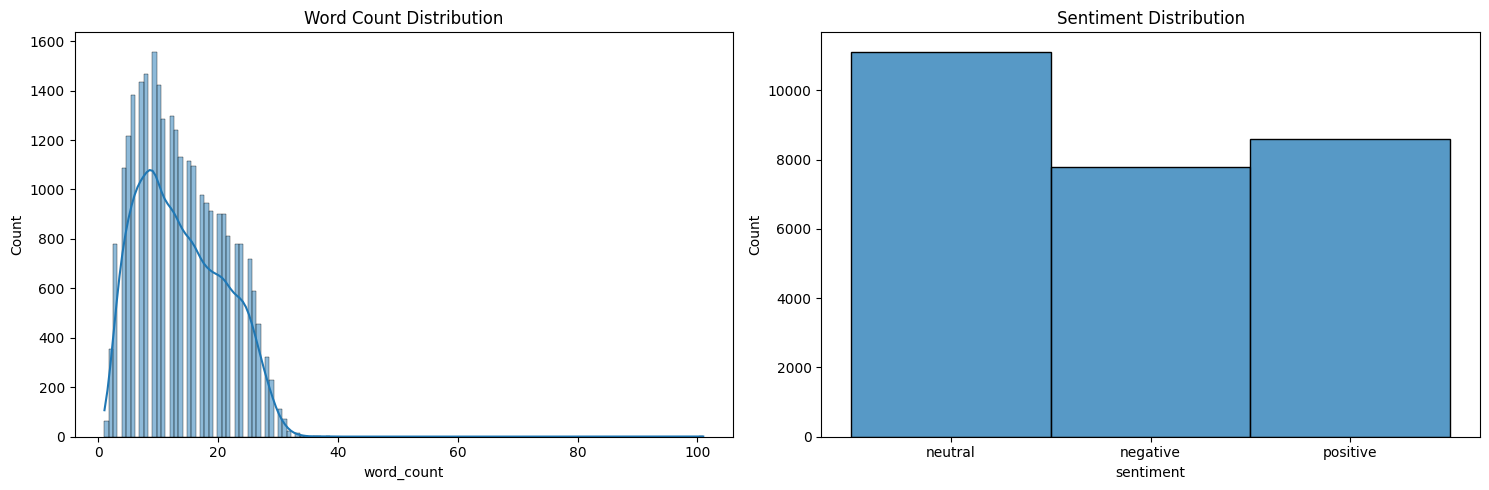

In [33]:
# prompt: create historgram plot of word_count and sentiment

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot word_count histogram
sns.histplot(twt_df['word_count'], ax=axes[0], kde=True)
axes[0].set_title('Word Count Distribution')

# Plot sentiment histogram
sns.histplot(twt_df['sentiment'], ax=axes[1])
axes[1].set_title('Sentiment Distribution')

plt.tight_layout()
plt.show()

<Axes: ylabel='word_count'>

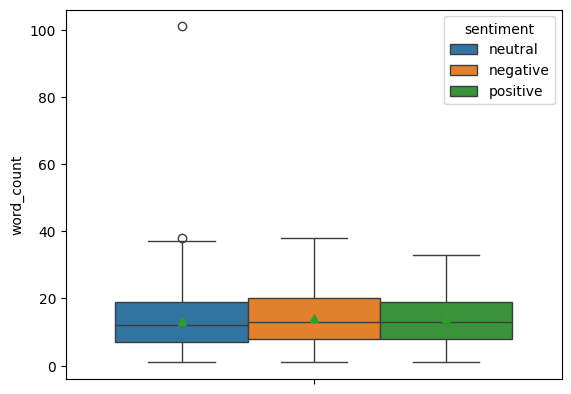

In [40]:
sns.boxplot(twt_df,y = "word_count", hue = "sentiment", showmeans = True)

In [45]:
import plotly.graph_objects as go

fig = go.Figure()

for sentiment, data in twt_df.groupby('sentiment'):
    fig.add_trace(go.Box(y=data['word_count'], name=sentiment, boxmean='sd'))

fig.show()


#Cleaning and Preprocessing Text

In [47]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [56]:
import string
def tensor_to_string(tensor):
    return tensor.numpy().decode('utf-8')
def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [57]:
twt_df["text"][0]

' I`d have responded, if I were going'

In [58]:
custom_standardization(twt_df["text"][0]).numpy()

b'  responded going'

In [62]:
# create a new column
twt_df["processed_text"] = twt_df['text'].apply(custom_standardization)

# convert tensor to string
twt_df["processed_text"] = twt_df["processed_text"].apply(tensor_to_string)

In [63]:
twt_df.head()

,text,sentiment,word_count,processed_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought


# Obtain frequency of words for Sentiment

In [64]:
positive_twt = twt_df[twt_df["sentiment"] == "positive"]
negative_twt = twt_df[twt_df["sentiment"] == "negative"]
neutral_twt = twt_df[twt_df["sentiment"] == "neutral"]

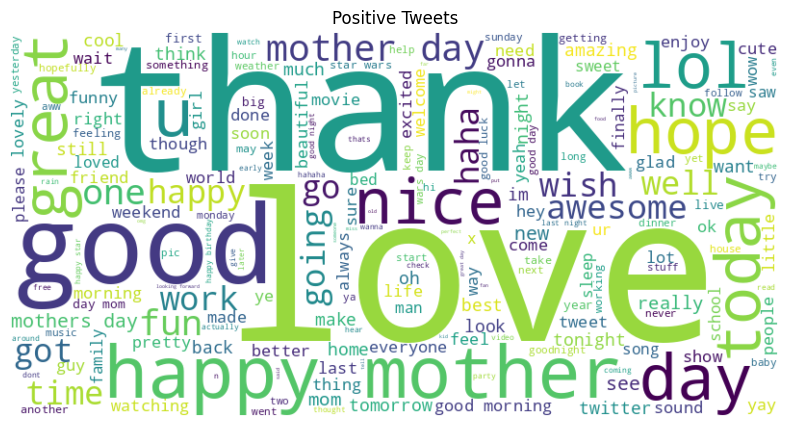

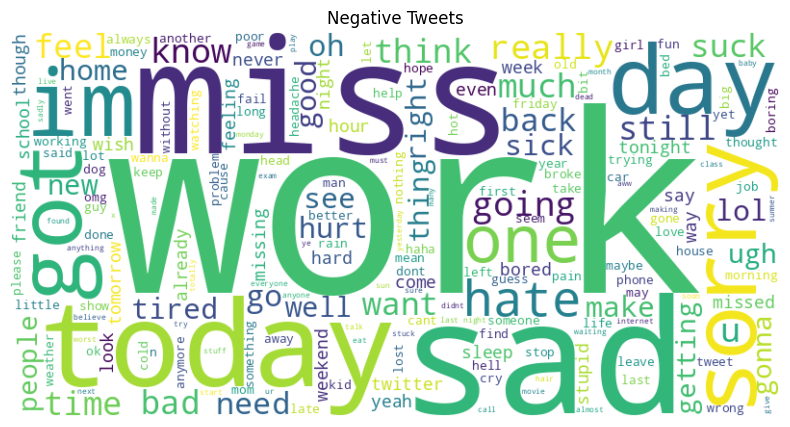

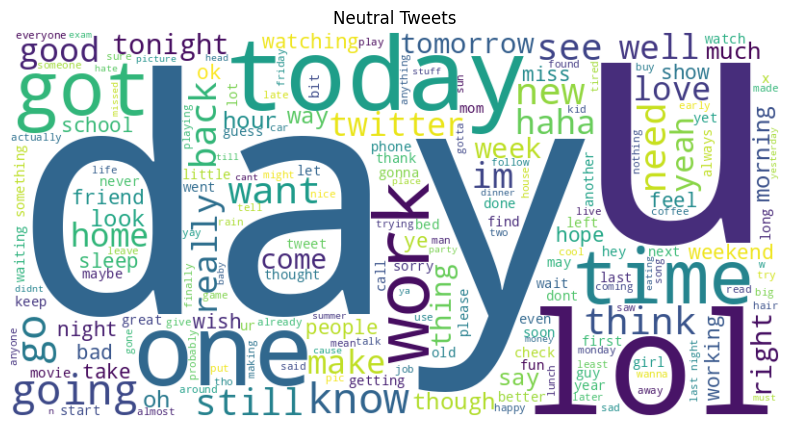

In [66]:
# prompt: create word cloud for posiitve_twt, negative and neutral /

from wordcloud import WordCloud

# Function to create and display a word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for each sentiment
create_wordcloud(positive_twt['processed_text'], 'Positive Tweets')
create_wordcloud(negative_twt['processed_text'], 'Negative Tweets')
create_wordcloud(neutral_twt['processed_text'], 'Neutral Tweets')

In [68]:
# convert sentiment to numeric
twt_df["sentiment"] = twt_df["sentiment"].map({"positive": 1, "negative": -1, "neutral": 0})

In [69]:
from tkinter.constants import X
# split into training test and split
from sklearn.model_selection import train_test_split
X_tra